In [ ]:
# Install dependencies (run once)
%pip install --quiet pythonnet numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


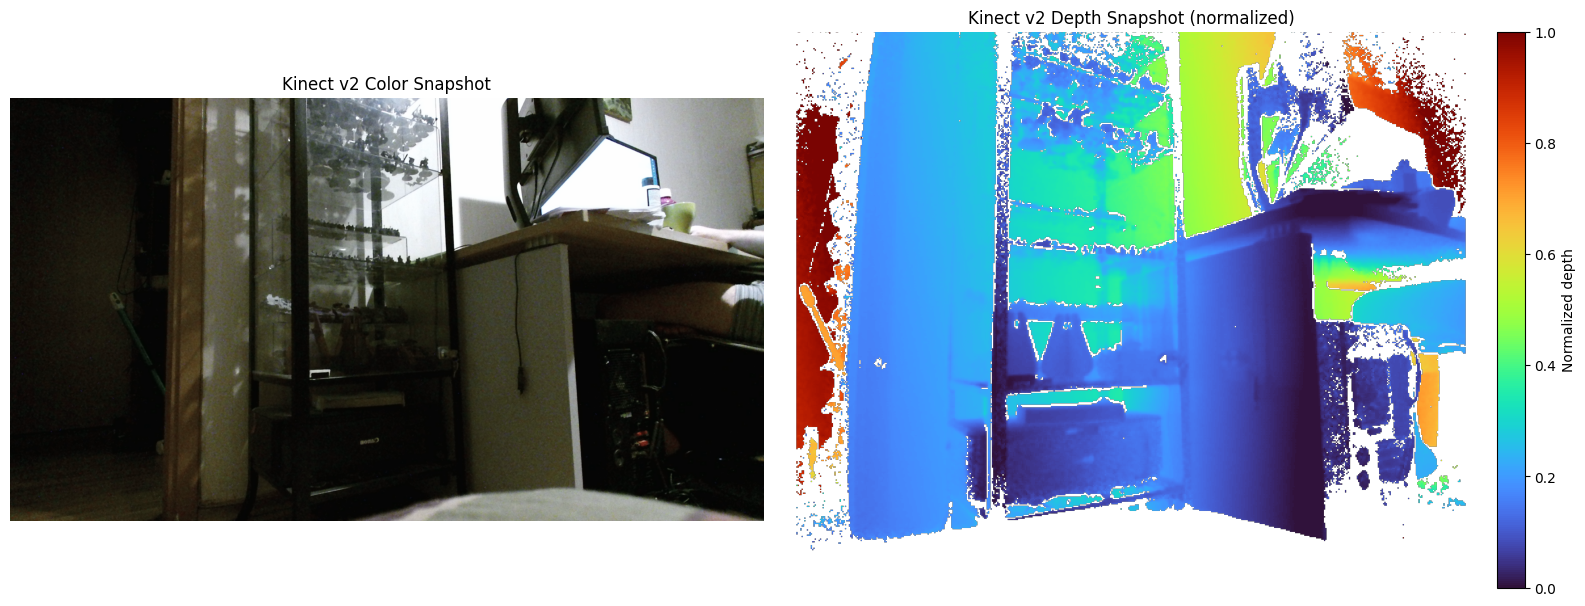

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from my_kinect import capture_kinect_snapshot, normalize_depth, KinectRuntimeError

WINDOWS_SDK_PATH = Path(r"C:\Program Files\Microsoft SDKs\Kinect\v2.0_1409\Assemblies")
sdk_path = WINDOWS_SDK_PATH if WINDOWS_SDK_PATH.exists() else None

try:
    color_rgb, depth_mm = capture_kinect_snapshot(
        initial_wait=1.5,
        timeout=12.0,
        sdk_path=sdk_path,
    )
except KinectRuntimeError as exc:
    raise RuntimeError(f"Failed to capture Kinect frames: {exc}") from exc

normalized_depth = normalize_depth(depth_mm)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(color_rgb)
axes[0].set_title("Kinect v2 Color Snapshot")
axes[0].axis("off")

im = axes[1].imshow(normalized_depth, cmap="turbo", origin="upper")
axes[1].set_title("Kinect v2 Depth Snapshot (normalized)")
axes[1].axis("off")
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label="Normalized depth")

plt.tight_layout()
plt.show()